In [2]:
# Import section
import os
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint ,EarlyStopping
from keras.layers import Dropout
from keras import optimizers
from keras import backend as K
import keras
from sklearn import svm
from tensorflow.keras.models import Sequential

adam = tf.keras.optimizers.Adam(learning_rate=0.0005)

2023-05-20 10:32:09.969592: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-20 10:32:10.032672: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-20 10:32:10.034630: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-20 10:32:11.253288: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
#loading data 
import numpy as np
import scipy.io
def dataloader(path,featType):#if featType = 1 ==> acoustic, if featType = 2 ==> acoustic+context
  data = scipy.io.loadmat(path)
  print(data.keys())
  if featType == 1:
    AF = data['AF']; x = AF[0:-2]; y = AF[-2]; w = AF[-1];
  else:
    AF = data['AF']; x1 = AF[0:-2]; x2 = data['CF']; y = AF[-2]; w = AF[-1]; 
    x = np.concatenate((x1,x2), axis=0)
  return x.T, y.T, w.T, data['CF_info']

In [4]:
import tensorflow as tf
!pip install tensorflow-addons
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
def normalization(feats,avg,std):
  ii=0
  for v in feats:
    # print(len(v))
    feats[ii] = np.divide((v-avg),std)
    ii = ii+1
  return feats

# better use np.norm for faster processing

In [6]:
# post processing the labels
def make_partitions(arr_words, arr_labels):
  v=[]
  np.array(v)
  temp=[]
  for i in range(len(arr_words)-1):
    word=arr_words[i]
    next_word=arr_words[i+1]
    temp.append(arr_labels[i])
    if word!=next_word:
      numpy_temp=np.array(temp)
      temp_max=np.amax(numpy_temp)
      numpy_temp=np.divide(numpy_temp, temp_max)
      v=np.concatenate((v, numpy_temp), axis=None)
      temp.clear()
    if (i==len(arr_words)-2):
      temp.append(arr_labels[i+1])
      numpy_temp=np.array(temp)
      temp_max=np.amax(numpy_temp)
      numpy_temp=np.divide(numpy_temp, temp_max)
      v=np.concatenate((v, numpy_temp), axis=None)
      temp.clear()
  v1=[]
  for i in v:
    if i==1:
      v1.append(1)
    else:
      v1.append(0)
  return v1

In [7]:
#Function to compute classification accuracy
# similarity measure
def calculate_accuracy(arr1, arr2):
  count=0
  for itr1, itr2 in zip(arr1, arr2):
    if itr1==itr2:
      count+=1
  return count/len(arr1)

In [8]:
import statistics
import keras.backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Dropout
from keras.layers import concatenate
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
from sklearn.metrics import f1_score

In [9]:
fatyp = 'TypicalFA_comb1'
drivepath = 'finalData/'+ fatyp +'/';
#featFiles = 'GER_train_fisher-2000_FA_GT_ESTphnTrans_estStress'               #glob.glob(drivepath + '*train*')
filee = drivepath+'GER_train_fisher-2000_FA_GT_ESTphnTrans_estStress.mat'
featType = 1; #Acoustic or Acoustic+context
if featType == 1:
  original_dim = 19
else:
  original_dim = 38

In [10]:
# print('Classification with::::::',os.path.basename(filee))

train_path = filee; test_path = filee.replace('train','test')
# print('test file:::::::',os.path.basename(test_path))
xtrain, ytrain, wtrain, info_train = dataloader(train_path, featType); 
xtrain1, ytrain1, wtrain1, info_train1 = dataloader(train_path, featType=2);

xtest, ytest, wtest ,info_test = dataloader(test_path, featType)
xtest1, ytest1, wtest1, info_test1 = dataloader(test_path, featType=2);



dict_keys(['__header__', '__version__', '__globals__', 'AF', 'AF_info', 'CF', 'CF_info'])
dict_keys(['__header__', '__version__', '__globals__', 'AF', 'AF_info', 'CF', 'CF_info'])
dict_keys(['__header__', '__version__', '__globals__', 'AF', 'AF_info', 'CF', 'CF_info'])
dict_keys(['__header__', '__version__', '__globals__', 'AF', 'AF_info', 'CF', 'CF_info'])


In [11]:
train_size = xtrain.shape[0]
print(train_size)
avg_trainfeat=np.mean(xtrain, axis=0)
std_trainfeat=np.std(xtrain, axis=0)

avg_trainfeat1=np.mean(xtrain1, axis=0)
std_trainfeat1=np.std(xtrain1, axis=0)

5891


In [12]:
xtest_a = normalization(xtest,avg_trainfeat,std_trainfeat)
xtest_ac = normalization(xtest1,avg_trainfeat1,std_trainfeat1)

xtrain = normalization(xtrain,avg_trainfeat,std_trainfeat)
xtrain1 = normalization(xtrain1,avg_trainfeat1,std_trainfeat1)

In [13]:
print(xtrain.shape)
woPP=[]; wPP=[]

input_shape1 = (19,)
input_shape2 = (38,)

temperature = 0.03
learning_rate=0.001

(5891, 19)


In [14]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=temperature, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        print(feature_vectors.shape)
        # labels = tf.keras.layers.Concatenate(axis=0)([labels, labels])
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)

        # Compute logits
        logits = tf.divide(tf.matmul(feature_vectors_normalized, tf.transpose(feature_vectors_normalized)), self.temperature)
        
        # print(feature_vectors.shape)
        # print(labels.shape)
        # print('loss:::::::', tfa.losses.npairs_loss(tf.squeeze(labels), logits))
        return 0.35*(tfa.losses.npairs_loss(tf.squeeze(labels), logits))
        #find out more about why 0.35 is used

In [15]:
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Input
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from keras.layers import Reshape


In [31]:
# latent_dim = 30

# class Encoder1(Model):
#   def __init__(self, latent_dim):
#     super(Encoder1, self).__init__()
#     self.latent_dim = latent_dim 
#     inputs = keras.Input(19,)
#     outputs = inputs  
#     self.encoder = tf.keras.Sequential([
#       inputs,
#       layers.Dense(128, activation='relu'),
#       layers.BatchNormalization(),
#       layers.Dropout(0.3),
#       layers.Dense(64, activation='relu'),
#       layers.Dense(32, activation='relu'),
#       layers.Dense(latent_dim, activation='relu'),
#     ])

#   def call(self, x):
#     encoded = self.encoder(x)
#     return encoded

def create_encoder1(latent_dim):
    encoder_input = Input(shape=(19,1))
    x1 = Conv1D(filters=64, kernel_size=2, activation='relu')(encoder_input)
    x2 = MaxPooling1D(pool_size=1)(x1)
    x3 = Dropout(0.5)(x2)
    x4 = Conv1D(filters=32, kernel_size=2, activation='relu')(x3)
    x5 = MaxPooling1D(pool_size=1)(x4)
    x6 = Flatten()(x5)
    output_layer = Dense(latent_dim, activation='relu')(x6)
    encoder1 = Model(encoder_input, output_layer)
    return encoder1

# class Encoder2(Model):
#   def __init__(self, latent_dim):
#     super(Encoder2, self).__init__()
#     self.latent_dim = latent_dim
#     inputs = keras.Input(38,)
#     outputs = inputs  
#     self.encoder = tf.keras.Sequential([
#       inputs,
#       layers.Dense(256, activation='relu'),
#       layers.BatchNormalization(),
#       layers.Dropout(0.5),
#       layers.Dense(128, activation='relu'),
#       layers.BatchNormalization(),
#       layers.Dropout(0.2),
#       layers.Dense(64, activation='relu'),
#       layers.Dense(32, activation='relu'),
#       layers.Dense(latent_dim, activation='relu'),
#     ])

def create_encoder2(latent_dim):
    encoder_input = Input(shape=(38,1))
    x1 = Conv1D(filters=64, kernel_size=2, activation='relu')(encoder_input)
    x2 = MaxPooling1D(pool_size=1)(x1)
    x3 = Dropout(0.5)(x2)
    x4 = Conv1D(filters=32, kernel_size=2, activation='relu')(x3)
    x5 = MaxPooling1D(pool_size=1)(x4)
    x6 = Flatten()(x5)
    output_layer = Dense(latent_dim, activation='relu')(x6)
    encoder2 = Model(encoder_input, output_layer)
    return encoder2

#   def call(self, x):
#     encoded = self.encoder(x)
#     return encoded

Encoder

In [32]:
latent_dim = 30

In [33]:
# def create_encoder1():
#   encoder_input = Input(shape=(19,1))
#   x1=Conv1D(filters=64, kernel_size=2, activation='relu')(encoder_input)
#   x2=MaxPooling1D(pool_size=1)(x1)
#   x3=tf.keras.layers.Dropout(0.5)(x2)
#   x4=Conv1D(filters=32, kernel_size=2, activation='relu')(x3)
#   x5=MaxPooling1D(pool_size=1)(x4)
#   x6=Flatten()(x5)

#   output_layer=Dense(latent_dim,activation='relu')(x6)

#   encoder1 = Model(encoder_input, output_layer)
#   return encoder1

In [34]:
# def create_encoder2():
#   encoder_input = Input(shape=(38,1))
#   x1=Conv1D(filters=64, kernel_size=2, activation='relu')(encoder_input)
#   x2=MaxPooling1D(pool_size=1)(x1)
#   x3=tf.keras.layers.Dropout(0.5)(x2)
#   x4=Conv1D(filters=32, kernel_size=2, activation='relu')(x3)
#   x5=MaxPooling1D(pool_size=1)(x4)
#   x6=Flatten()(x5)

#   output_layer=Dense(latent_dim,activation='relu')(x6)
# # x2=Dense(64,activation='relu')(x1)
# # x3=Dense(32,activation='relu')(x2)
# # x4=Dense(16,activation='relu')(x3)
# # x5=Dense(8,activation='relu')(x4)
# # x6=Dense(4,activation='relu')(x5)
# # output_layer = Dense(1, activation='sigmoid')(x1)

#   encoder2 = Model(encoder_input, output_layer)
#   return encoder2

In [35]:
# def add_projection_head1(Encoder1, Encoder2):
#   inp1 = keras.Input(shape=input_shape1)
#   inp2 = keras.Input(shape=input_shape2)
#   encoder_input = Input(shape=(38,1))
#   x1=Conv1D(filters=64, kernel_size=2, activation='relu')(encoder_input)
#   x2=MaxPooling1D(pool_size=1)(x1)
#   x3=tf.keras.layers.Dropout(0.5)(x2)
#   x4=Conv1D(filters=32, kernel_size=2, activation='relu')(x3)
#   x5=MaxPooling1D(pool_size=1)(x4)
#   x6=Flatten()(x5)

#   output_layer=Dense(latent_dim,activation='relu')(x6)
# # x2=Dense(64,activation='relu')(x1)
# # x3=Dense(32,activation='relu')(x2)
# # x4=Dense(16,activation='relu')(x3)
# # x5=Dense(8,activation='relu')(x4)
# # x6=Dense(4,activation='relu')(x5)
# # output_layer = Dense(1, activation='sigmoid')(x1)

#   encoder2 = Model(encoder_input, output_layer)
#   return encoder2

In [36]:
# # def create_encoder1():
# #     return Encoder1(latent_dim)

# # def create_encoder2():
# #     return Encoder2(latent_dim)

def add_projection_head1(Encoder1, Encoder2):
    inp1 = keras.Input(shape=input_shape1)
    inp2 = keras.Input(shape=input_shape2)
    hidden3a  = Encoder1(inp1)
    hidden3b = Encoder2(inp2)
    features = tf.keras.layers.Concatenate(axis=1)([hidden3a, hidden3b])
    features = layers.Dense(16, activation="relu")(features)
    model = keras.Model(
        inputs=[inp1, inp2], outputs=features, name="cifar-encoder_with_projection-head"
    )
    return model

In [37]:
# def add_projection_head1():
#     latent_dim = 10
#     # Encoder 1
#     encoder_input1 = Input(shape=(19, 1))
#     x1_1 = Conv1D(filters=64, kernel_size=2, activation='relu')(encoder_input1)
#     x2_1 = MaxPooling1D(pool_size=1)(x1_1)
#     x3_1 = Dropout(0.5)(x2_1)
#     x4_1 = Conv1D(filters=32, kernel_size=2, activation='relu')(x3_1)
#     x5_1 = MaxPooling1D(pool_size=1)(x4_1)
#     x6_1 = Flatten()(x5_1)
#     output_layer1 = Dense(latent_dim, activation='relu')(x6_1)
#     encoder1 = Model(encoder_input1, output_layer1)

#     # Encoder 2
#     encoder_input2 = Input(shape=(38, 1))
#     x1_2 = Conv1D(filters=64, kernel_size=2, activation='relu')(encoder_input2)
#     x2_2 = MaxPooling1D(pool_size=1)(x1_2)
#     x3_2 = Dropout(0.5)(x2_2)
#     x4_2 = Conv1D(filters=32, kernel_size=2, activation='relu')(x3_2)
#     x5_2 = MaxPooling1D(pool_size=1)(x4_2)
#     x6_2 = Flatten()(x5_2)
#     output_layer2 = Dense(latent_dim, activation='relu')(x6_2)
#     encoder2 = Model(encoder_input2, output_layer2)

#     # Concatenated Projection Model
#     concatenated_output = tf.keras.layers.concatenate([output_layer1, output_layer2])
#     projection_model = Model(inputs=[encoder_input1, encoder_input2], outputs=concatenated_output)
    
#     return projection_model

In [38]:
def create_classifier(encoder, trainable):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs1 = keras.Input(shape=input_shape1)
    inputs2 = keras.Input(shape=input_shape2)
    features1 = encoder1(inputs1)
    features2 = encoder2(inputs2)
    features = tf.keras.layers.Concatenate(axis=1)([features1, features2])
    # features = layers.Dropout(0.2)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    
    features = layers.BatchNormalization()(features)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(32, activation="relu")(features)
    features = layers.Dropout(0.2)(features)
    features = layers.Dense(16, activation="relu")(features)
    # features = layers.BatchNormalization()(features)
    # features = layers.Dropout(0.2)(features)
    features = layers.Dense(4, activation="relu")(features)
    # features = layers.BatchNormalization()(features)
    # features = layers.Dropout(0.1)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=[inputs1,inputs2], outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

In [39]:
for j in range(0,5): # folds 

  xval_a = xtrain[(train_size*j)//5:(train_size*(j+1))//5];
  print(xval_a.shape)
  yval_a = ytrain[(train_size*j)//5:(train_size*(j+1))//5]
  xtra_a = np.concatenate((xtrain[:(train_size*j)//5], xtrain[((train_size*(j+1))//5):]), axis=0) 
  ytra_a = np.concatenate((ytrain[:(train_size*j)//5], ytrain[((train_size*(j+1))//5):]), axis=0)
  # print('Fold  '+str(j+1)+'  xtrain shape:::::::', xtra_a.shape)

  xval_ac = xtrain1[(train_size*j)//5:(train_size*(j+1))//5];
  print(xval_ac.shape)
  yval_ac = ytrain1[(train_size*j)//5:(train_size*(j+1))//5]
  xtra_ac = np.concatenate((xtrain1[:(train_size*j)//5], xtrain1[((train_size*(j+1))//5):]), axis=0)
  ytra_ac = np.concatenate((ytrain1[:(train_size*j)//5], ytrain1[((train_size*(j+1))//5):]), axis=0)
  y = np.concatenate((ytra_a,ytra_a), axis=0)
  yv = np.concatenate((yval_a,yval_a), axis=0)
  print(yval_ac.shape)
  #check what's happening here is it intended
  encoder1 = create_encoder1(latent_dim=10)
  encoder2 = create_encoder2(10)
  encoder_with_projection_head = add_projection_head1(encoder1,encoder2)
  encoder_with_projection_head.compile(optimizer=keras.optimizers.Adam(learning_rate),loss=SupervisedContrastiveLoss(temperature))
  encoder_with_projection_head.summary()
                                                            #ytra_a                                  #yval_a
  history = encoder_with_projection_head.fit([xtra_a,xtra_ac], ytra_ac , validation_data =([xval_a,xval_ac],yval_ac), batch_size=32, epochs=1, callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)])


  learning_rate = 0.0005
  batch_size = 16
  hidden_units = 64
  projection_units = 128
  num_epochs = 200
  dropout_rate = 0.3
  num_classes = 2
  input_shape1 = (19,)
  input_shape2 = (38,)

  from keras.callbacks import ModelCheckpoint ,EarlyStopping
  classifier = create_classifier(encoder_with_projection_head, trainable=False)
  classifier.summary()
  history = classifier.fit(x=[xtra_a,xtra_ac], y=ytra_ac, validation_data =([xval_a,xval_ac],yval_ac), batch_size=batch_size, epochs=num_epochs, callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)])

  accuracy = classifier.evaluate([xtest_a,xtest_ac], ytest)[1]

  ##  Accuracy on post processed labels (each word should contain only one stressed syllable)
  pred_output= classifier.predict([xtest_a,xtest_ac])
  # pred_labels= pred_output.argmax(axis =1)
  pred1_labels = pred_output[:,1]
  post_labels = make_partitions(wtest, pred1_labels)
  post_accuracy = calculate_accuracy(post_labels, ytest)

  F1_score_WoPP = f1_score(ytest, pred_output.argmax(axis =1))
  F1_score_WPP = f1_score(ytest, post_labels)

  print(f"Test accuracy: {round(accuracy * 100, 3)}%")
  print(f"Postprocessing Test accuracy: {round(post_accuracy * 100, 3)}%")
  print(f"Test F1_score: {round(F1_score_WoPP * 100, 3)}%")
  print(f"Postprocessing F1_score: {round(F1_score_WPP * 100, 3)}%")


(1178, 19)
(1178, 38)
(1178,)
Model: "cifar-encoder_with_projection-head"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 19)]         0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 38)]         0           []                               
                                                                                                  
 model_5 (Functional)           (None, 10)           9770        ['input_13[0][0]']               
                                                                                                  
 model_6 (Functional)           (None, 10)           15850       ['input_14[0][0]']               
                                   

KeyboardInterrupt: 

In [ ]:
# def create_classifier():

#     # for layer in encoder.layers:
#     #     layer.trainable = trainable

#     # inputs1 = keras.Input(shape=input_shape1)
#     inputs2 = keras.Input(shape=input_shape2)
#     # features1 = encoder1(inputs1)
#     # features2 = encoder2(inputs2)
#     # features = tf.keras.layers.Concatenate(axis=1)([features1, features2])
#     # # features = layers.Dropout(0.2)(features)
#     features = layers.Dense(64, activation="relu")(inputs2)
    
#     features = layers.BatchNormalization()(features)
#     features = layers.Dropout(dropout_rate)(features)
#     features = layers.Dense(32, activation="relu")(features)
#     features = layers.Dropout(0.2)(features)
#     features = layers.Dense(16, activation="relu")(features)
#     # features = layers.BatchNormalization()(features)
#     # features = layers.Dropout(0.2)(features)
#     features = layers.Dense(4, activation="relu")(features)
#     # features = layers.BatchNormalization()(features)
#     # features = layers.Dropout(0.1)(features)
#     outputs = layers.Dense(num_classes, activation="softmax")(features)

#     model = keras.Model(inputs=inputs2, outputs=outputs)
#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate),
#         loss=keras.losses.SparseCategoricalCrossentropy(),
#         metrics=[keras.metrics.SparseCategoricalAccuracy()],
#     )
#     return model

In [ ]:
# for j in range(0,1): # folds 

#   xval_a = xtrain[(train_size*j)//5:(train_size*(j+1))//5];
#   print(xval_a.shape)
#   yval_a = ytrain[(train_size*j)//5:(train_size*(j+1))//5]
#   xtra_a = np.concatenate((xtrain[:(train_size*j)//5], xtrain[((train_size*(j+1))//5):]), axis=0) 
#   ytra_a = np.concatenate((ytrain[:(train_size*j)//5], ytrain[((train_size*(j+1))//5):]), axis=0)
#   # print('Fold  '+str(j+1)+'  xtrain shape:::::::', xtra_a.shape)

#   xval_ac = xtrain1[(train_size*j)//5:(train_size*(j+1))//5];
#   print(xval_ac.shape)
#   yval_ac = ytrain1[(train_size*j)//5:(train_size*(j+1))//5]
#   xtra_ac = np.concatenate((xtrain1[:(train_size*j)//5], xtrain1[((train_size*(j+1))//5):]), axis=0)
#   ytra_ac = np.concatenate((ytrain1[:(train_size*j)//5], ytrain1[((train_size*(j+1))//5):]), axis=0)
#   y = np.concatenate((ytra_a,ytra_a), axis=0)
#   yv = np.concatenate((yval_a,yval_a), axis=0)
#   #check what's happening here is it intended
#   # encoder1 = create_encoder1()
#   # encoder2 = create_encoder2()
#   # encoder_with_projection_head = add_projection_head1(encoder1, encoder2)
#   # encoder_with_projection_head.compile(optimizer=keras.optimizers.Adam(learning_rate),loss=SupervisedContrastiveLoss(temperature))
#   # encoder_with_projection_head.summary()
#   #                                                           #ytra_a                                  #yval_a
#   # history = encoder_with_projection_head.fit([xtra_a,xtra_ac], ytra_a , validation_data =([xval_a,xval_ac],yval_a), batch_size=32, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)])


#   learning_rate = 0.0005
#   batch_size = 16
#   hidden_units = 64
#   projection_units = 128
#   num_epochs = 200
#   dropout_rate = 0.3
#   num_classes = 2
#   input_shape1 = (19,)
#   input_shape2 = (38,)

#   from keras.callbacks import ModelCheckpoint ,EarlyStopping
#   classifier = create_classifier()
#   classifier.summary()
#   history = classifier.fit(x=xtra_ac, y=ytra_a, validation_data =(xval_ac,yval_a), batch_size=batch_size, epochs=num_epochs, callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)])

#   accuracy = classifier.evaluate(xtest_ac, ytest)[1]

#   ##  Accuracy on post processed labels (each word should contain only one stressed syllable)
#   pred_output= classifier.predict(xtest_ac)
#   # pred_labels= pred_output.argmax(axis =1)
#   pred1_labels = pred_output[:,1]
#   post_labels = make_partitions(wtest, pred1_labels)
#   post_accuracy = calculate_accuracy(post_labels, ytest)

#   F1_score_WoPP = f1_score(ytest, pred_output.argmax(axis =1))
#   F1_score_WPP = f1_score(ytest, post_labels)

#   print(f"Test accuracy: {round(accuracy * 100, 3)}%")
#   print(f"Postprocessing Test accuracy: {round(post_accuracy * 100, 3)}%")
#   print(f"Test F1_score: {round(F1_score_WoPP * 100, 3)}%")
#   print(f"Postprocessing F1_score: {round(F1_score_WPP * 100, 3)}%")

In [ ]:
accuracy = classifier.evaluate(xtest_ac, ytest)[1]
print(accuracy)
##  Accuracy on post processed labels (each word should contain only one stressed syllable)
pred_output= classifier.predict(xtest_ac)
# pred_labels= pred_output.argmax(axis =1)
pred1_labels = pred_output[:,1]
post_labels = make_partitions(wtest, pred1_labels)
post_accuracy = calculate_accuracy(post_labels, ytest)

F1_score_WoPP = f1_score(ytest, pred_output.argmax(axis=1))
F1_score_WPP = f1_score(ytest, post_labels)

print(f"Test accuracy: {round(accuracy * 100, 3)}%")
print(f"Postprocessing Test accuracy: {round(post_accuracy * 100, 3)}%")
print(f"Test F1_score: {round(F1_score_WoPP * 100, 3)}%")
print(f"Postprocessing F1_score: {round(F1_score_WPP * 100, 3)}%")

150/150 [==============================] - 0s 2ms/step - loss: 0.2706 - sparse_categorical_accuracy: 0.8918
0.8918354511260986
150/150 [==============================] - 0s 2ms/step
Test accuracy: 89.184%
Postprocessing Test accuracy: 93.067%
Test F1_score: 88.136%
Postprocessing F1_score: 92.114%


#single iteration

In [ ]:
j = 0  # Single iteration

xval_a = xtrain[(train_size*j)//5:(train_size*(j+1))//5]
print(xval_a.shape)
yval_a = ytrain[(train_size*j)//5:(train_size*(j+1))//5]
xtra_a = np.concatenate((xtrain[:(train_size*j)//5], xtrain[((train_size*(j+1))//5):]), axis=0)
ytra_a = np.concatenate((ytrain[:(train_size*j)//5], ytrain[((train_size*(j+1))//5):]), axis=0)

xval_ac = xtrain1[(train_size*j)//5:(train_size*(j+1))//5]
print(xval_ac.shape)
yval_ac = ytrain1[(train_size*j)//5:(train_size*(j+1))//5]
xtra_ac = np.concatenate((xtrain1[:(train_size*j)//5], xtrain1[((train_size*(j+1))//5):]), axis=0)
ytra_ac = np.concatenate((ytrain1[:(train_size*j)//5], ytrain1[((train_size*(j+1))//5):]), axis=0)

y = np.concatenate((ytra_a, ytra_a), axis=0)
yv = np.concatenate((yval_a, yval_a), axis=0)

encoder1 = create_encoder1()
encoder2 = create_encoder2()
encoder_with_projection_head = add_projection_head1(encoder1, encoder2)
encoder_with_projection_head.compile(optimizer=keras.optimizers.Adam(learning_rate), loss=SupervisedContrastiveLoss(temperature))
encoder_with_projection_head.summary()

history = encoder_with_projection_head.fit([xtra_a, xtra_ac], ytra_a, validation_data=([xval_a, xval_ac], yval_a), batch_size=32, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)])

(1178, 19)
(1178, 38)
Model: "cifar-encoder_with_projection-head"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 19)]         0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 38)]         0           []                               
                                                                                                  
 encoder1 (Encoder1)            (None, 10)           13738       ['input_11[0][0]']               
                                                                                                  
 encoder2 (Encoder2)            (None, 10)           55082       ['input_12[0][0]']               
                                           

In [ ]:
learning_rate = 0.0005
batch_size = 16
hidden_units = 64
projection_units = 128
num_epochs = 200
dropout_rate = 0.3
num_classes = 2
input_shape1 = (19,)
input_shape2 = (38,)

from keras.callbacks import ModelCheckpoint, EarlyStopping
classifier = create_classifier(encoder_with_projection_head, trainable=False)
classifier.summary()

history = classifier.fit(x=[xtra_a, xtra_ac], y=ytra_a, validation_data=([xval_a, xval_ac], yval_a), batch_size=batch_size, epochs=num_epochs, callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)])

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 19)]         0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 38)]         0           []                               
                                                                                                  
 encoder1 (Encoder1)            (None, 10)           13738       ['input_13[0][0]']               
                                                                                                  
 encoder2 (Encoder2)            (None, 10)           55082       ['input_14[0][0]']               
                                                                                            

In [ ]:
accuracy = classifier.evaluate([xtest_a, xtest_ac], ytest)[1]
print(accuracy)
##  Accuracy on post processed labels (each word should contain only one stressed syllable)
pred_output= classifier.predict([xtest_a,xtest_ac])
# pred_labels= pred_output.argmax(axis =1)
pred1_labels = pred_output[:,1]
post_labels = make_partitions(wtest, pred1_labels)
post_accuracy = calculate_accuracy(post_labels, ytest)

F1_score_WoPP = f1_score(ytest, pred_output.argmax(axis=1))
F1_score_WPP = f1_score(ytest, post_labels)

print(f"Test accuracy: {round(accuracy * 100, 3)}%")
print(f"Postprocessing Test accuracy: {round(post_accuracy * 100, 3)}%")
print(f"Test F1_score: {round(F1_score_WoPP * 100, 3)}%")
print(f"Postprocessing F1_score: {round(F1_score_WPP * 100, 3)}%")

150/150 [==============================] - 0s 2ms/step - loss: 2.3964 - sparse_categorical_accuracy: 0.7304
0.7304238677024841
150/150 [==============================] - 1s 2ms/step
Test accuracy: 73.042%
Postprocessing Test accuracy: 79.578%
Test F1_score: 67.925%
Postprocessing F1_score: 76.781%


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting xtrain and ytrain into training and validation sets
xtra_a, xval_a, ytra_a, yval_a = train_test_split(xtrain, ytrain, test_size=0.2, random_state=42)

# Splitting xtrain1 and ytrain1 into training and validation sets
xtra_ac, xval_ac, ytra_ac, yval_ac = train_test_split(xtrain1, ytrain1, test_size=0.2, random_state=42)

In [ ]:
def create_classifier():

    # for layer in encoder.layers:
    #     layer.trainable = trainable

    inputs1 = keras.Input(shape=input_shape1)
    # inputs2 = keras.Input(shape=input_shape2)
    # features1 = encoder1(inputs1)
    # features2 = encoder2(inputs2)
    # features = tf.keras.layers.Concatenate(axis=1)([features1, features2])
    # # features = layers.Dropout(0.2)(features)
    features = layers.Dense(64, activation="relu")(inputs1)
    features = layers.BatchNormalization()(features)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(32, activation="relu")(features)
    features = layers.Dropout(0.2)(features)
    features = layers.Dense(16, activation="relu")(features)
    # features = layers.BatchNormalization()(features)
    # features = layers.Dropout(0.2)(features)
    features = layers.Dense(4, activation="relu")(features)
    # features = layers.BatchNormalization()(features)
    # features = layers.Dropout(0.1)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs1, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model


learning_rate = 0.0005
batch_size = 16
hidden_units = 64
projection_units = 128
num_epochs = 200
dropout_rate = 0.3
num_classes = 2
input_shape1 = (19,)
input_shape2 = (38,)

from keras.callbacks import ModelCheckpoint, EarlyStopping
classifier = create_classifier()
classifier.summary()

history = classifier.fit(x=xtra_a, y=ytra_a, validation_data=(xval_a, yval_a), batch_size=batch_size, epochs=num_epochs, callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 19)]              0         
                                                                 
 dense_5 (Dense)             (None, 64)                1280      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                           

In [ ]:
print(len(post_labels))

9578


In [ ]:
accuracy = classifier.evaluate(xtest_a, ytest)[1]
print(accuracy)
##  Accuracy on post processed labels (each word should contain only one stressed syllable)
pred_output= classifier.predict(xtest_a)
# pred_labels= pred_output.argmax(axis =1)
pred1_labels = pred_output
post_labels = make_partitions(wtest, pred1_labels)
post_accuracy = calculate_accuracy(post_labels, ytest)

F1_score_WoPP = f1_score(ytest, pred_output.argmax(axis=1))


print(f"Test accuracy: {round(accuracy * 100, 3)}%")
print(f"Postprocessing Test accuracy: {round(post_accuracy * 100, 3)}%")
print(f"Test F1_score: {round(F1_score_WoPP * 100, 3)}%")
# print(f"Postprocessing F1_score: {round(F1_score_WPP * 100, 3)}%")

150/150 [==============================] - 0s 3ms/step - loss: 0.4110 - sparse_categorical_accuracy: 0.8158
0.8158279657363892
150/150 [==============================] - 0s 3ms/step
Test accuracy: 81.583%
Postprocessing Test accuracy: 26.999%
Test F1_score: 79.218%


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting xtrain and ytrain into training and validation sets
xtra_a, xval_a, ytra_a, yval_a = train_test_split(xtrain, ytrain, test_size=0.2, random_state=42)

# Splitting xtrain1 and ytrain1 into training and validation sets
xtra_ac, xval_ac, ytra_ac, yval_ac = train_test_split(xtrain1, ytrain1, test_size=0.2, random_state=42)

In [ ]:
def create_classifier():

    inputs2 = keras.Input(shape=input_shape2)
    # features1 = encoder1(inputs1)
    # features2 = encoder2(inputs2)
    # features = tf.keras.layers.Concatenate(axis=1)([features1, features2])
    # # features = layers.Dropout(0.2)(features)
    features = layers.Dense(128, activation="relu")(inputs2)
    # features = layers.BatchNormalization()(features)
    features = layers.Dropout(0.3)(features)
    features = layers.Dense(64, activation="relu")(features)
    # features = layers.BatchNormalization()(features)
    features = layers.Dropout(0.3)(features)
    features = layers.Dense(32, activation="relu")(features)
    features = layers.Dropout(0.2)(features)
    features = layers.Dense(16, activation="relu")(features)
    # features = layers.BatchNormalization()(features)
    # features = layers.Dropout(0.2)(features)
    features = layers.Dense(4, activation="relu")(features)
    # features = layers.BatchNormalization()(features)
    # features = layers.Dropout(0.1)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs2, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

In [ ]:
learning_rate = 0.0005
batch_size = 64
hidden_units = 64
projection_units = 128
num_epochs = 200
dropout_rate = 0.3
num_classes = 2
input_shape1 = (19,)
input_shape2 = (38,)

from keras.callbacks import ModelCheckpoint, EarlyStopping
classifier = create_classifier()
classifier.summary()

history = classifier.fit(x=xtra_ac, y=ytra_a, validation_data=(xval_ac, yval_a), batch_size=batch_size, epochs=num_epochs, callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)])

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 38)]              0         
                                                                 
 dense_38 (Dense)            (None, 128)               4992      
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_39 (Dense)            (None, 64)                8256      
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_40 (Dense)            (None, 32)                2080      
                                                                 
 dropout_19 (Dropout)        (None, 32)                0   

In [ ]:
accuracy = classifier.evaluate(xtest_ac, ytest)[1]
print(accuracy)
##  Accuracy on post processed labels (each word should contain only one stressed syllable)
pred_output= classifier.predict(xtest_ac)
# pred_labels= pred_output.argmax(axis =1)
pred1_labels = pred_output[:,1]
post_labels = make_partitions(wtest, pred1_labels)
post_accuracy = calculate_accuracy(post_labels, ytest)

F1_score_WoPP = f1_score(ytest, pred_output.argmax(axis=1))
F1_score_WPP = f1_score(ytest, post_labels)

print(f"Test accuracy: {round(accuracy * 100, 3)}%")
print(f"Postprocessing Test accuracy: {round(post_accuracy * 100, 3)}%")
print(f"Test F1_score: {round(F1_score_WoPP * 100, 3)}%")
print(f"Postprocessing F1_score: {round(F1_score_WPP * 100, 3)}%")

150/150 [==============================] - 0s 2ms/step - loss: 3.1447 - sparse_categorical_accuracy: 0.7617
0.7617456912994385
150/150 [==============================] - 0s 1ms/step
Test accuracy: 76.175%
Postprocessing Test accuracy: 82.585%
Test F1_score: 68.314%
Postprocessing F1_score: 80.199%


In [ ]:
print(pred_output)

[[0.00365241 0.9963476 ]
 [0.9952295  0.00477048]
 [0.9386474  0.06135263]
 ...
 [0.14561768 0.8543823 ]
 [0.98402655 0.01597348]
 [0.9824058  0.01759416]]


In [ ]:
inaccurate_indices = []
for i in range(len(post_labels)):
    if post_labels[i] != ytest[i]:
        inaccurate_indices.append(i)
print(len(inaccurate_indices))

314


In [ ]:
new_array = xtest_a[inaccurate_indices]

In [ ]:
print(new_array)

[[-0.32618123 -0.11955624 -0.43673654 ...  1.28741675 -0.18443
  -0.43610226]
 [-0.27862984 -0.47228711 -0.17909384 ...  0.64660961 -0.18443
  -1.09067232]
 [ 0.12251953 -0.33604709 -0.45253141 ...  0.79238856 -0.70591123
  -0.57529244]
 ...
 [ 0.99006663  0.717825    0.88522703 ... -0.52146543  0.73265766
   0.23727729]
 [-0.76690572 -0.98085484 -0.90234678 ... -0.68461169 -0.51277003
  -0.5026236 ]
 [-0.328765   -0.37839626 -0.71037262 ... -0.91981712  1.12893011
   1.15774923]]


In [ ]:
fatyp = 'TypicalFA_comb1'
drivepath = '/content/drive/MyDrive/finalData/'+ fatyp +'/';
#featFiles = 'GER_train_fisher-2000_FA_GT_ESTphnTrans_estStress'               #glob.glob(drivepath + '*train*')
filee = drivepath+'GER_train_fisher-2000_FA_GT_ESTphnTrans_estStress.mat'
train_path = filee; test_path = filee.replace('train','test')
data = scipy.io.loadmat(train_path)
print(data.keys())
AF = data['AF']
print(AF.shape)

dict_keys(['__header__', '__version__', '__globals__', 'AF', 'AF_info', 'CF', 'CF_info'])
(21, 5891)


In [ ]:
zeros_count = np.count_nonzero(AF == 20, axis=0)
print(len(zeros_count))

5891


In [ ]:
second_to_last_row = AF[-2, :]

# Count the number of zeros in the second-to-last row
zeros_count = np.count_nonzero(second_to_last_row == 0)

# Print the count
print("Number of zeros in the second-to-last row:", zeros_count)

# Count the number of zeros in the second-to-last row
ones_count = np.count_nonzero(second_to_last_row == 1)

# Print the count
print("Number of ones in the second-to-last row:", ones_count)


Number of zeros in the second-to-last row: 3313
Number of ones in the second-to-last row: 2578


In [ ]:
saving = AF[:,inaccurate_indices]

In [ ]:
print(saving.shape)

(21, 314)


In [ ]:
scipy.io.savemat('check.mat', {'matrix_name':saving})

In [ ]:
pred1_labels = pred_output[:, 1]
print(pred1_labels.shape)
print(pred1_labels)
post_labels = make_partitions(wtest, pred1_labels)
print(post_labels)

(4789,)
[0.997248   0.02355868 0.02213604 ... 0.9652264  0.01718037 0.00157761]
[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0

upto here only


# Single iteration upto here

In [ ]:
pred_output.argmax(axis =1)

array([1, 0, 0, ..., 1, 0, 0])

In [ ]:
ytest

array([1., 0., 0., ..., 1., 0., 0.])

In [ ]:
f1_score(ytest, pred_output.argmax(axis =1))

0.8835322195704057

In [ ]:
f1_score(ytest, post_labels)

0.9268408551068883

In [ ]:
output_layer = classifier.layers[-2].output
new_model = Model(inputs=classifier.input, outputs=output_layer)

# generate some input data
input_data = [xtest_a, xtest_ac]

# use the predict method to get the output from the last-but-one layer
output = new_model.predict(input_data)

150/150 [==============================] - 1s 3ms/step


In [ ]:
from keras.utils import to_categorical
# x_tra_a_enco=encoder1(xtest_a)
# x_tra_ac_enco=encoder2(xtest_ac)
# xtra_enco = tf.keras.layers.Concatenate(axis=1)([x_tra_a_enco, x_tra_ac_enco])
xtra_enco = output
# ytra_a_enco = to_categorical(ytest)

ytra_a_enco = ytest


import numpy as np
import math
from sklearn.manifold import TSNE

import matplotlib.colors as c
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from subprocess import call
vis_dim = 2

x_train_encoded = TSNE(n_components=vis_dim).fit_transform(xtra_enco)

print(x_train_encoded[:,0])
print(x_train_encoded[:,1])
print(c=y_train[:n_predict])

def vis_data(x_train_encoded, y_train, vis_dim, n_predict, n_train, build_anim):
    cmap = plt.get_cmap('rainbow', 10)

    
    # 3-dim vis: show one view, then compile animated .gif of many angled views
    if vis_dim == 3:
        # Simple static figure
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        p = ax.scatter3D(x_train_encoded[:,0], x_train_encoded[:,1], x_train_encoded[:,2], 
                c=y_train[:n_predict], cmap=cmap, edgecolor='black')
        fig.colorbar(p, drawedges=True)
        plt.show()

        # Build animation from many static figures
        if build_anim:
            angles = np.linspace(180, 360, 20)
            i = 0
            for angle in angles:
                fig = plt.figure()
                ax = plt.axes(projection='3d')
                ax.view_init(10, angle)
                p = ax.scatter3D(x_train_encoded[:,0], x_train_encoded[:,1], x_train_encoded[:,2], 
                        c=y_train[:n_predict], cmap=cmap, edgecolor='black')
                fig.colorbar(p, drawedges=True)
                outfile = 'anim/3dplot_step_' + chr(i + 97) + '.png'
                plt.savefig(outfile, dpi=96)
                i += 1
            call(['convert', '-delay', '50', 'anim/3dplot*', 'anim/3dplot_anim_' + str(n_train) + '.gif'])

    # 2-dim vis: plot and colorbar.
    elif vis_dim == 2:
        plt.scatter(x_train_encoded[:,0], x_train_encoded[:,1], c=y_train[:n_predict], edgecolor='black', cmap=cmap)
        plt.colorbar(drawedges=True)
        plt.show()


[-30.487669    17.733316    37.919586   ... -56.286472    40.302948
   0.24058552]
[ 62.970608  -8.572245  45.509453 ... -11.506646   9.219881  71.06346 ]


NameError: ignored

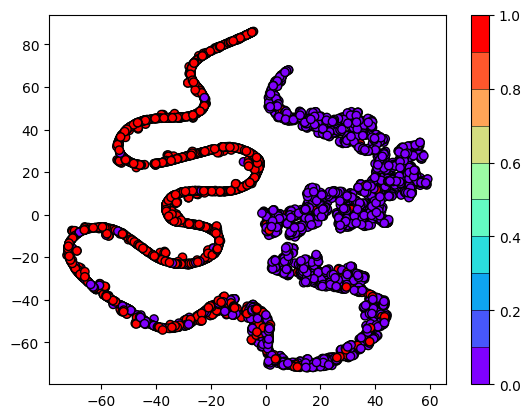

In [ ]:
train_new = False
n_train = 4789
predict_new = False
n_predict = 4789
vis_dim = 2
build_anim = False

vis_data(x_train_encoded, ytra_a_enco, vis_dim, n_predict, n_train, build_anim)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from keras.layers import Input, Dense
from keras.models import Model
import seaborn as sns

185/185 [==============================] - 1s 4ms/step
(5891, 10)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5891 samples in 0.012s...
[t-SNE] Computed neighbors for 5891 samples in 0.470s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5891
[t-SNE] Computed conditional probabilities for sample 2000 / 5891
[t-SNE] Computed conditional probabilities for sample 3000 / 5891
[t-SNE] Computed conditional probabilities for sample 4000 / 5891
[t-SNE] Computed conditional probabilities for sample 5000 / 5891
[t-SNE] Computed conditional probabilities for sample 5891 / 5891
[t-SNE] Mean sigma: 0.185905
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.901894
[t-SNE] KL divergence after 1000 iterations: 1.119865


<ipython-input-87-179baf66a2e8>:10: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),


[Text(0.5, 1.0, 'MNIST data T-SNE projection')]

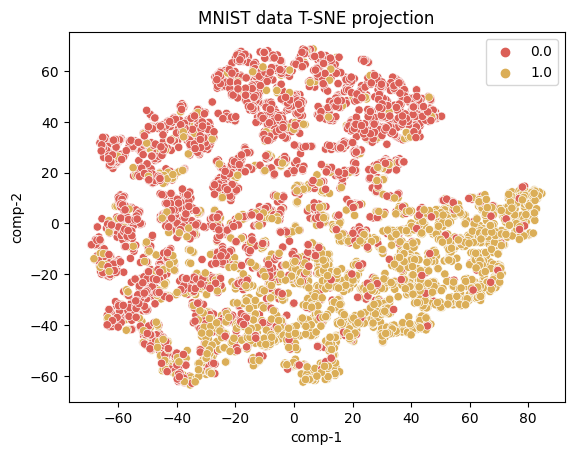

In [ ]:
encoded_data = encoder1.predict(xtrain)
print(encoded_data.shape)
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(encoded_data)
df = pd.DataFrame()
df["y"] = ytrain
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="MNIST data T-SNE projection")

In [ ]:
def create_classifier(encoder, trainable):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs1 = keras.Input(shape=input_shape1)
    inputs2 = keras.Input(shape=input_shape2)
    features1 = encoder1(inputs1)
    features2 = encoder2(inputs2)
    features = tf.keras.layers.Concatenate(axis=1)([features1, features2])
    # features = layers.Dropout(0.2)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dense(hidden_units//2, activation="relu")(features)
    features = layers.Dropout(0.1)(features)
    features = layers.Dense(hidden_units//2, activation="relu")(features)
    # features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=[inputs1,inputs2], outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model


learning_rate = 0.001
batch_size = 32
hidden_units = 128
projection_units = 128
num_epochs = 200
dropout_rate = 0.2
temperature = 0.05
num_classes = 2
input_shape1 = (19,)
input_shape2 = (38,)

from keras.callbacks import ModelCheckpoint ,EarlyStopping
classifier = create_classifier(encoder_with_projection_head, trainable=False)

history = classifier.fit(x=[xtra_a,xtra_ac], y=ytra_a, validation_data =([xval_a,xval_ac],yval_a), batch_size=batch_size, epochs=num_epochs, callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)])

accuracy = classifier.evaluate([xtest_a,xtest_ac], ytest)[1]
print(f"Test accuracy: {round(accuracy * 100, 3)}%")

Epoch 1/200
148/148 [==============================] - 7s 21ms/step - loss: 0.2550 - sparse_categorical_accuracy: 0.9017 - val_loss: 0.3346 - val_sparse_categorical_accuracy: 0.8821
Epoch 2/200
148/148 [==============================] - 1s 6ms/step - loss: 0.2030 - sparse_categorical_accuracy: 0.9295 - val_loss: 0.3469 - val_sparse_categorical_accuracy: 0.8838
Epoch 3/200
148/148 [==============================] - 1s 7ms/step - loss: 0.1888 - sparse_categorical_accuracy: 0.9353 - val_loss: 0.3474 - val_sparse_categorical_accuracy: 0.8830
Epoch 4/200
148/148 [==============================] - 1s 5ms/step - loss: 0.1845 - sparse_categorical_accuracy: 0.9338 - val_loss: 0.3756 - val_sparse_categorical_accuracy: 0.8821
Epoch 5/200
148/148 [==============================] - 1s 5ms/step - loss: 0.1860 - sparse_categorical_accuracy: 0.9283 - val_loss: 0.3486 - val_sparse_categorical_accuracy: 0.8821
Epoch 6/200
148/148 [==============================] - 1s 5ms/step - loss: 0.1908 - sparse_cat

In [ ]:
a = encoder1(xtra_a)
print(a.shape)
b = encoder2(xtra_ac)
print(b.shape)

(4713, 16)
(4713, 16)


In [ ]:
features = tf.keras.layers.Concatenate(axis=1)([a, b])

In [ ]:
features.shape

TensorShape([4713, 32])

In [ ]:
feature_vectors_normalized = tf.math.l2_normalize(features, axis=0)

In [ ]:
feature_vectors_normalized.shape

TensorShape([4713, 32])

In [ ]:
logits = tf.divide(tf.matmul(feature_vectors_normalized, tf.transpose(feature_vectors_normalized)), 0.2)

In [ ]:
logits.shape

TensorShape([4713, 4713])

In [ ]:
labels = tf.squeeze(ytra_a)

In [ ]:
labels.shape

TensorShape([4713])

In [ ]:
print(tfa.losses.npairs_loss(labels, logits))

tf.Tensor(8.457547, shape=(), dtype=float32)


In [ ]:
import statistics
import keras.backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Dropout
from keras.layers import concatenate
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

fatyp = 'TypicalFA_comb1'
drivepath = '/content/drive/MyDrive/finalData/'+ fatyp +'/';
#featFiles = 'GER_train_fisher-2000_FA_GT_ESTphnTrans_estStress'               #glob.glob(drivepath + '*train*')
filee = drivepath+'GER_train_fisher-2000_FA_GT_ESTphnTrans_estStress.mat'
featType = 1; #Acoustic or Acoustic+context
if featType == 1:
  original_dim = 19
else:
  original_dim = 38
#intermediate_dim = 64;  latent_dim = 19
WPP_accuracies_avg = []; WoPP_accuracies_avg = [];WPP_all =[]; WoPP_all=[];names=[]
WPP_accuracies_std = []; WoPP_accuracies_std = [];
# print(featFiles)

print('Classification with::::::',os.path.basename(filee))

train_path = filee; test_path = filee.replace('train','test')
print('test file:::::::',os.path.basename(test_path))
xtrain, ytrain, wtrain, info_train = dataloader(train_path, featType); 
xtrain1, ytrain1, wtrain1, info_train1 = dataloader(train_path, featType=2);

xtest, ytest, wtest ,info_test = dataloader(test_path, featType)
# xtest1, ytest1, wtest1, info_test1 = dataloader(test_path, featType=2);

train_size = xtrain.shape[0]
print(train_size)
avg_trainfeat=np.mean(xtrain, axis=0)
std_trainfeat=np.std(xtrain, axis=0)

avg_trainfeat1=np.mean(xtrain1, axis=0)
std_trainfeat1=np.std(xtrain1, axis=0)


xtest = normalization(xtest,avg_trainfeat,std_trainfeat)
xtrain = normalization(xtrain,avg_trainfeat,std_trainfeat)
xtrain1 = normalization(xtrain1,avg_trainfeat1,std_trainfeat1)

print(xtrain.shape)
woPP=[]; wPP=[]

for j in range(1,2): # folds 

  xval_a = xtrain[(train_size*j)//5:(train_size*(j+1))//5];
  print(xval_a.shape)
  yval_a = ytrain[(train_size*j)//5:(train_size*(j+1))//5]
  xtra_a = np.concatenate((xtrain[:(train_size*j)//5], xtrain[((train_size*(j+1))//5):]), axis=0); 
  ytra_a = np.concatenate((ytrain[:(train_size*j)//5], ytrain[((train_size*(j+1))//5):]), axis=0)
  print('Fold  '+str(j+1)+'  xtrain shape:::::::', xtra_a.shape)

  xval_ac = xtrain1[(train_size*j)//5:(train_size*(j+1))//5];
  print(xval_ac.shape)
  yval_ac = ytrain1[(train_size*j)//5:(train_size*(j+1))//5]
  xtra_ac = np.concatenate((xtrain1[:(train_size*j)//5], xtrain1[((train_size*(j+1))//5):]), axis=0); 
  ytra_ac = np.concatenate((ytrain1[:(train_size*j)//5], ytrain1[((train_size*(j+1))//5):]), axis=0)

  lab_input = keras.Input(shape=(1,), name="lab_input")
  inp1 = Input(shape=(19,))
  hidden1a = Dense(32, activation='relu')(inp1)
  x = Dense(128, activation='relu')(hidden1a)
  x = Dropout(0.3)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(32, activation='relu')(x)
  hidden3a = Dense(16, activation='relu')(x)
  # outputa = Dense(1, activation='sigmoid')(hidden3a)
  # model1 = Model(inputs=inp1, outputs=outputa)


  inp2 = Input(shape=(38,))
  hidden1b = Dense(32, activation='relu')(inp2)
  x = Dense(128, activation='relu')(hidden1b)
  x = Dropout(0.2)(x)
  x = Dense(64, activation='relu')(x)
  # x = Dropout(0.2)(x)
  x = Dense(32, activation='relu')(x)
  hidden3b = Dense(16, activation='relu')(x)
  # outputb = Dense(1, activation='sigmoid')(hidden3)
  # model2 = Model(inputs=inp2, outputs=outputb)

  x = concatenate([hidden3a, hidden3b])
  out = Dense(16, activation='relu')(x)
  x = Dropout(0.2)(x)
  out = Dense(4, activation='relu')(out)
  out = Dense(1, activation='sigmoid')(out)
  model = Model(inputs=[inp1, inp2], outputs=out)#outputs=[[hidden3a,hidden3b],out]

  

  model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy']) #['binary_crossentropy',loss]
  model.summary()
  callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)]

  model.fit([ xtra_a, xtra_ac], ytra_a
           , epochs=200, batch_size=32)


Classification with:::::: GER_train_fisher-2000_FA_GT_ESTphnTrans_estStress.mat
test file::::::: GER_test_fisher-2000_FA_GT_ESTphnTrans_estStress.mat
dict_keys(['__header__', '__version__', '__globals__', 'AF', 'AF_info', 'CF', 'CF_info'])
dict_keys(['__header__', '__version__', '__globals__', 'AF', 'AF_info', 'CF', 'CF_info'])
dict_keys(['__header__', '__version__', '__globals__', 'AF', 'AF_info', 'CF', 'CF_info'])
5891
(5891, 19)
(1178, 19)
Fold  2  xtrain shape::::::: (4713, 19)
(1178, 38)
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 19)]         0           []                               
                                                                                                  
 dense_78 (Dense)               (None, 32)           640         ['input_37[0][0]']      

KeyboardInterrupt: ignored